# Soft mixing

Adding some weighted correlation between the two tasks.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 2375343802  # this one is very interesting
set_all_seeds(seed)
print(seed)

3124371287


## Model

Keeping this extremely simple

In [4]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [5]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5

# lambda weighting
λ = 0.2


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

nY0 = (1 - λ) * Y[:, 0] + λ * Y[:, 1]
nY1 = λ * Y[:, 0] + (1 - λ) * Y[:, 1]
Y = torch.cat((nY0.unsqueeze(1), nY1.unsqueeze(1)), dim=1)

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


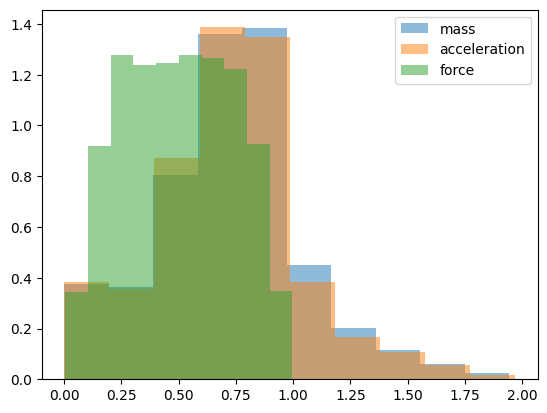

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

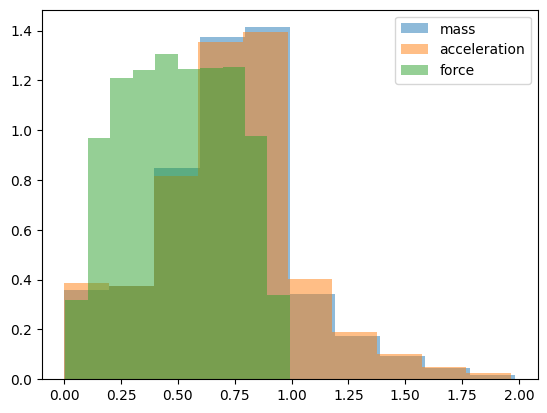

In [7]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [8]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [9]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [10]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

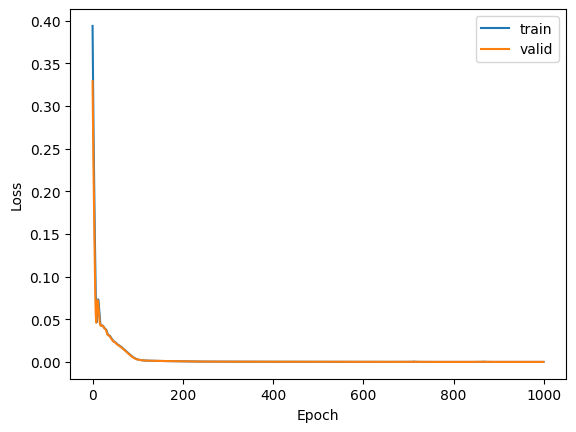

In [11]:
plot_loss(df["train_loss"], df["valid_loss"])

In [12]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [13]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0002)

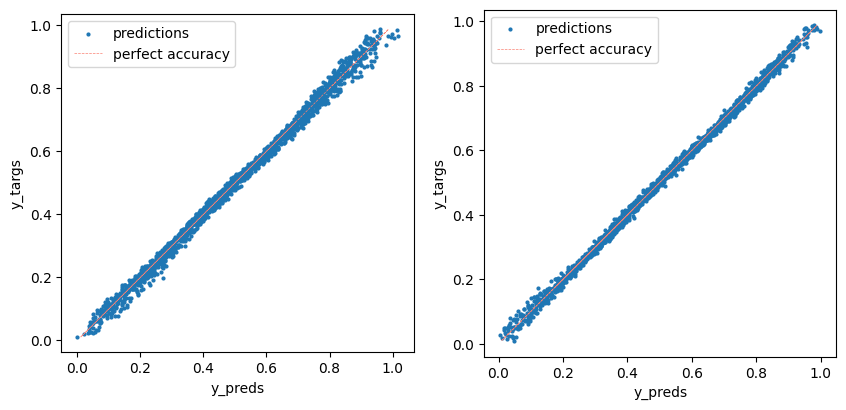

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [15]:
from physics_mi.analysis import capture_intermediate_outputs

In [16]:
def get_task_inputs(N=100, vary_task="A"):
    """
    Generates a dataset with N^2 examples for one of the two tasks (A or B). In each task subset, the other task's
    inputs are held constant and the alternative's task's inputs are varied across all the
    possible values in the interval [0,1] with precision 1/N.

    The purpose is to allow us to study how different tasks are represented in the dataset.

    Args:
        N (int, optional): Number of steps to sample unit input square. Defaults to 100.
        vary_task (str, optional): Which task to vary (the other's inputs will remained fixed at [0.5,0.5]). Defaults to "A".

    Returns:
        data: (N^2,4) the task dataset
    """
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [17]:
task_inputs = torch.cat((get_task_inputs(100, vary_task="A"), get_task_inputs(100, vary_task="B")))
task_inputs.shape

torch.Size([20000, 4])

In [18]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios["input"] = task_inputs

In [19]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [20]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [21]:
from physics_mi.graph import generate_graph, add_plot_coords, nx_graph_from_pandas

In [22]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)
ndf = add_plot_coords(ndf, layer_keys)
G = nx_graph_from_pandas(ndf, edf)

In [23]:
from physics_mi.analysis import plot_similarity_matrix, get_sims

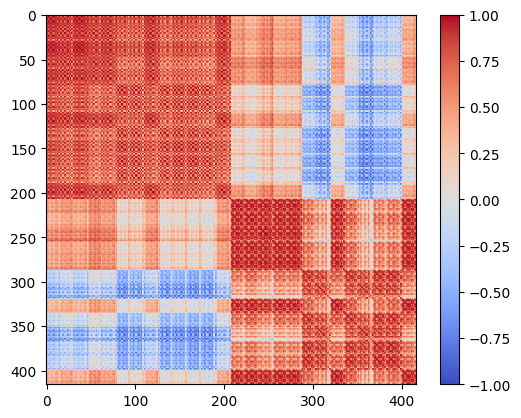

In [24]:
sims = get_sims(ndf, layer_keys[0])
plot_similarity_matrix(sims)